In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [9]:
df = pd.read_json('/content/drive/MyDrive/magazine_dataset.json')
df.head()

,overall,reviewText
0,5,"for computer enthusiast, MaxPC is a welcome si..."
1,5,Thank god this is not a Ziff Davis publication...
2,3,Antiques Magazine is a publication made for an...
3,5,This beautiful magazine is in itself a work of...
4,5,A great read every issue.


### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [10]:

df['overall'] = df['overall'].replace([1,2,3], [0,0,0])

df['overall'] = df['overall'].replace([4,5], [1,1])

In [11]:
X,y = df['reviewText'].values,df['overall'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (59979,)
shape of test data is (19994,)


### Analysing sentiment

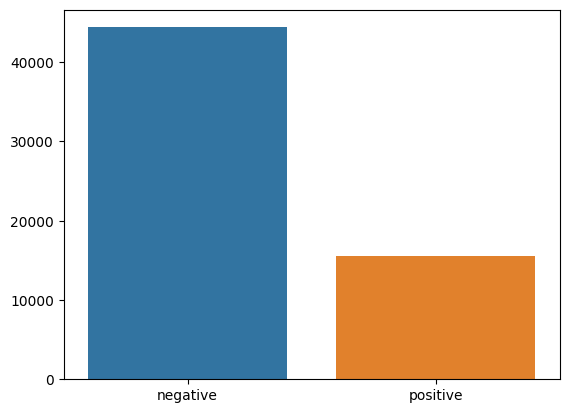

In [12]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tockenization

In [13]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-13-d52b72f03a89>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [16]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

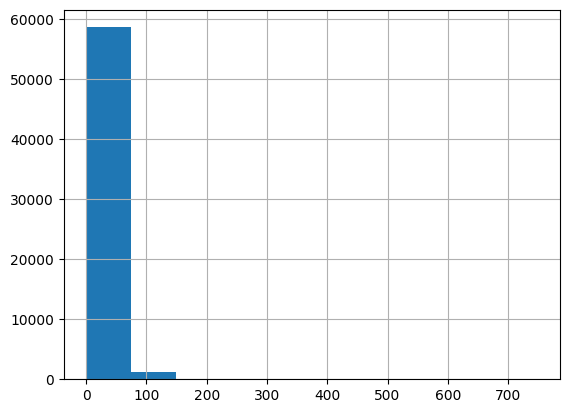

count    59979.000000
mean        16.136448
std         21.077306
min          0.000000
25%          5.000000
50%         10.000000
75%         19.000000
max        748.000000
dtype: float64

In [17]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 69.<br> b) minimum length of reviews is 2.<br>c)There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length 

In [1]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [19]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)


### Batching and loading as tensor

In [20]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [21]:
dataiter = iter(train_loader)
sample = next(dataiter)

sample_x = sample[0]
sample_y = sample[1]

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample labels: \n', sample_y)


Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 482, 976,  10],
        [  0,   0,   0,  ..., 368, 190, 273],
        [  0,   0,   0,  ..., 231,  27, 224],
        ...,
        [  0,   0,   0,  ..., 200,  17,  27],
        [  0,   0,   0,  ...,   0,   2,   1],
        [  0,   0,   0,  ...,  84, 154,  76]])
Sample labels: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [22]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [23]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [24]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [26]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        try:
          output,h = model(inputs,h)
        except:
          print('skippedd')
          continue
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)
            try:

              output, val_h = model(inputs, val_h)
            except:
              continue
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/drive/MyDrive/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

skippedd
Epoch 1
train_loss : 2.5511199134171368e-06 val_loss : 1.1498879394709723e-06
train_accuracy : 99.9516497440771 val_accuracy : 99.77993398019406
Validation loss decreased (inf --> 0.000001).  Saving model ...
skippedd
Epoch 2
train_loss : 9.257221435241221e-07 val_loss : 4.844737875949096e-07
train_accuracy : 99.9516497440771 val_accuracy : 99.77993398019406
Validation loss decreased (0.000001 --> 0.000000).  Saving model ...
skippedd
Epoch 3
train_loss : 4.254086043342579e-07 val_loss : 2.3206923047463507e-07
train_accuracy : 99.9516497440771 val_accuracy : 99.77993398019406
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
skippedd
Epoch 4
train_loss : 2.1547275346575022e-07 val_loss : 1.1739473799415074e-07
train_accuracy : 99.9516497440771 val_accuracy : 99.77993398019406
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
skippedd
Epoch 5
train_loss : 1.1336757437209893e-07 val_loss : 6.104296674930608e-08
train_accuracy : 99.9516497440

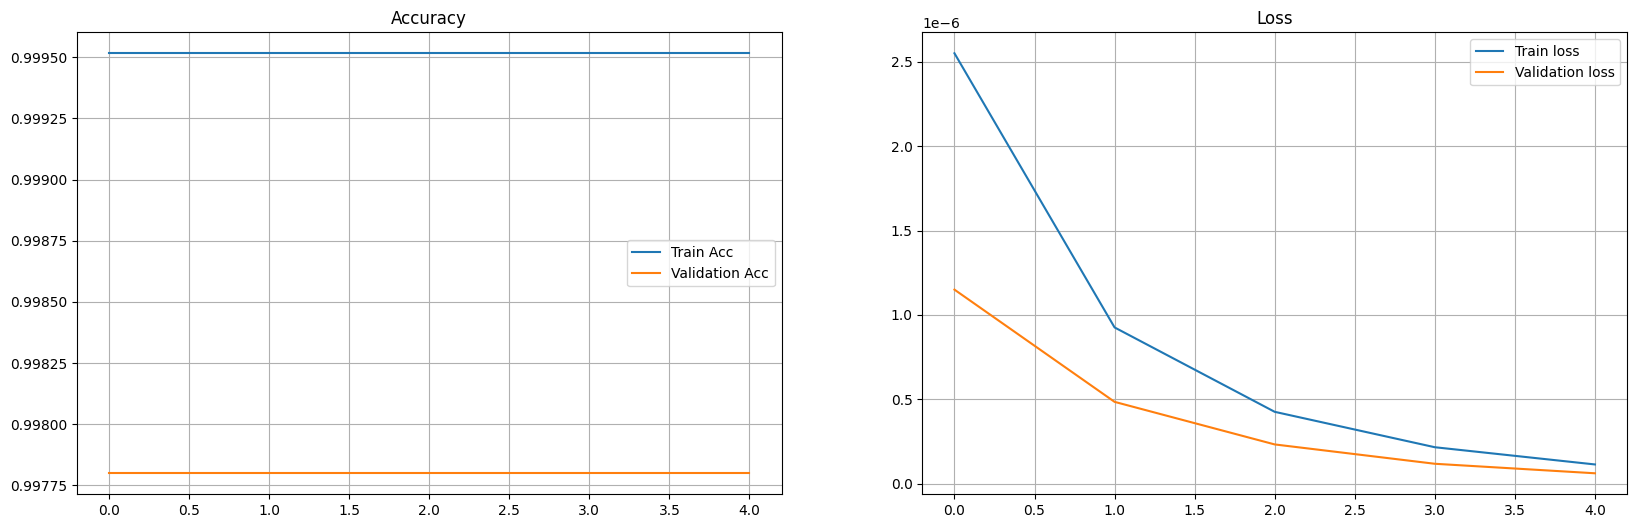

In [27]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Inferance

In [28]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [29]:

index = 31
print(df['reviewText'][index])
print('='*70)
print(f'Actual sentiment is  : {df["overall"][index]}')
print('='*70)
pro = predict_text(df['reviewText'][index])
status = "positive" if pro < 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Been a subscriber to this magazine for years and got an awesome deal purchasing the two year package. Great price and first issues showed up earlier than expected! Would renew when the time comes.
Actual sentiment is  : 1
Predicted sentiment is positive with a probability of 6.102557392750896e-08


In [30]:

index = 36
print(df['reviewText'][index])
print('='*70)
print(f'Actual sentiment is  : {df["overall"][index]}')
print('='*70)
pro = predict_text(df['reviewText'][index])
status = "positive" if pro < 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I used to subscribe to Todays Homeowner, a great rag.  Unfortunately it was purchased by This Old House which covers what the rich and famous own.  It's great to have dreams, but for those who want to act on them, or more appropriately, the rest of us, there is Family Handyman.
For help redoing a floor, rehabbing a kitchen, replacing a deck,  discussions on the latest techniques you will want Family Handiman.  A great product easy to read in 30 minutes, with just the right amount of coverage with great pictures.
Actual sentiment is  : 1
Predicted sentiment is positive with a probability of 6.101393523749721e-08


Some improvement suggestions are as follow:

* Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
